# **About Dataset**
**ECG Machine Image Dataset for Vitals Extraction**
**Image data of ECG machines for vital extraction like SpO2, Heart Rate, MAP etc.**
[link text](https://www.kaggle.com/datasets/pranjalverma08/icu-image-extraction)

Pada penelitian ini, penulis berfokus pada pengelolaan dataset yang telah disiapkan. Dataset ini terdiri dari 2000 file JPEG yang berisi gambar EKG yang diambil menggunakan kamera. Dalam implementasi kode ini, kami memutuskan untuk menggunakan hanya 100 gambar dari total dataset tersebut. Pembagian dataset dilakukan dengan rasio 80:20, di mana 80% akan digunakan untuk tahap pelatihan (train), dan 20% sisanya akan digunakan sebagai data validasi (val).

Selain itu, untuk tahap "Randomly Select and Detect Objects in Test Images," kami akan mengambil sampel secara acak dari dataset asli. Dalam konteks ini, kami memilih 3 gambar secara acak dari total 2000 dataset yang akan digunakan untuk menguji kemampuan model dalam mendeteksi objek pada gambar. Proses ini memberikan representasi kecil dari dataset secara keseluruhan, memungkinkan kita untuk menguji dan mengevaluasi kinerja model pada contoh-contoh yang bervariasi.

# **Install Ultralytics Package from GitHub**

In [40]:
# Install the ultralytics package from GitHub
!pip install -q git+https://github.com/ultralytics/ultralytics.git@main

  Preparing metadata (setup.py) ... done


# **Import Libraries**

In [ ]:
# Import library yang diperlukan
import os
import random
from ultralytics import YOLO
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import torch
import shutil
import onnx

# **Initialize Global Variables**
Tahap Initialize Global Variables pada kode ini bertujuan untuk menetapkan nilai-nilai awal kepada variabel global yang akan digunakan dalam seluruh skrip atau program. Variabel-variabel tersebut mencakup path menuju direktori dataset, model, logs, hasil (results), konfigurasi, serta path untuk data validasi dan input pengujian. Inisialisasi ini memastikan bahwa semua path dan variabel terkait telah didefinisikan dengan benar sebelum digunakan dalam operasi lebih lanjut. Variabel-variabel ini mencakup path ke direktori dataset yang berisi data pelatihan dan validasi, path menuju direktori model yang akan disimpan, path untuk menyimpan log (logs) dari pelatihan model, path hasil prediksi (results), path konfigurasi model YOLOv8, serta path untuk data validasi dan input pengujian. Penggunaan variabel-variabel global ini mempermudah pengelolaan dan pemanggilan path pada seluruh skrip, sehingga memastikan konsistensi dan keterbacaan kode.

In [11]:
import torc# Inisialisasi variabel global
dataset_path = '/content/drive/MyDrive/YOLO/dataset'
model_path = '/content/drive/MyDrive/YOLO/model'
logs_path = '/content/drive/MyDrive/YOLO/Logs'
results_path = '/content/drive/MyDrive/YOLO/results'
config_path = '/content/drive/MyDrive/YOLO/config'
val_test_path = '/content/drive/MyDrive/YOLO/test' #for val test
test_input_path = '/content/drive/MyDrive/data-ecg2/images'
names = ['ekg']

# **Create YAML Configuration File for Dataset**
Tahap Create YAML Configuration File for Dataset dalam kode ini bertujuan untuk membuat file konfigurasi YAML yang akan digunakan untuk menyimpan detail dataset yang akan digunakan dalam pelatihan model YOLOv8. Pada tahap ini, sebuah file YAML baru dibuat dengan menggunakan informasi yang telah ditentukan sebelumnya, seperti path menuju direktori data pelatihan dan validasi (train dan val), jumlah kelas (nc), dan nama-nama kelas (names). File konfigurasi ini nantinya akan digunakan oleh model YOLOv8 untuk mengakses dan memproses dataset yang sesuai. Pertama, path menuju direktori data pelatihan (train) dan data validasi (val) ditentukan sesuai dengan variabel dataset_path dan val_test_path. Selanjutnya, jumlah kelas (nc) diatur sesuai dengan jumlah kelas yang ada, dan nama-nama kelas (names) ditentukan. Informasi-informasi ini kemudian digunakan untuk mengisi konten dari file YAML yang dibuat. File YAML ini penting karena berfungsi sebagai panduan bagi model YOLOv8 untuk mengetahui di mana letak dataset, jumlah kelas yang ada, dan apa saja nama kelasnya. Dengan adanya file konfigurasi ini, pengguna dapat dengan mudah mengonfigurasi dataset yang akan digunakan tanpa perlu memodifikasi skrip secara langsung, meningkatkan fleksibilitas dan keberlanjutan pada pengembangan model.

In [3]:
# Buat file konfigurasi YAML untuk dataset
data_yaml_path = os.path.join(config_path, 'yolov8_dataset.yaml')
data_yaml_content = f"""train: {dataset_path}
val: {val_test_path}
nc: 1
names: {names}
"""

with open(data_yaml_path, 'w') as data_yaml:
    data_yaml.write(data_yaml_content)

print(f"File '{data_yaml_path}' berhasil dibuat.")

File '/content/drive/MyDrive/YOLO/config/yolov8_dataset.yaml' berhasil dibuat.


# **Initialize YOLOv8 Model**
Pada tahap inisialisasi ini, model YOLOv8 telah terkonfigurasi dengan parameter default yang dapat digunakan sebagai dasar untuk pelatihan dan evaluasi. Inisialisasi model menjadi langkah kritis dalam penggunaan YOLOv8, karena model yang telah diinisialisasi dapat digunakan untuk melakukan berbagai tugas seperti pelatihan dengan dataset, evaluasi kinerja, dan prediksi deteksi objek pada gambar atau video.

Model YOLOv8 ini memiliki kemampuan untuk melakukan deteksi objek pada gambar atau video dengan cepat dan akurat. Dengan menggunakan model ini, pengguna dapat mengimplementasikan deteksi objek secara efisien tanpa perlu membuat model dari awal. Model yang telah diinisialisasi ini kemudian dapat disesuaikan lebih lanjut sesuai dengan kebutuhan proyek, seperti pengaturan parameter pelatihan, opsi augmentasi, dan konfigurasi kelas objek yang ingin dideteksi.

Selanjutnya, model ini dapat digunakan untuk melibatkan proses pelatihan, evaluasi, dan prediksi pada tahap-tahap selanjutnya dalam pengembangan aplikasi deteksi objek menggunakan YOLOv8.







In [12]:
# Inisialisasi model YOLOv8
model = YOLO()

# **Train Model**
Pada tahap pelatihan, berbagai parameter seperti jumlah epoch (iterasi melalui seluruh dataset), ukuran batch, dan ukuran gambar yang digunakan untuk pelatihan diatur sesuai dengan kebutuhan proyek. Hasil pelatihan disimpan dalam variabel results dan dapat digunakan untuk mengevaluasi performa model pada dataset validasi setelah pelatihan selesai. Proses pelatihan ini melibatkan iterasi berulang kali melalui dataset pelatihan, di mana model secara bertahap menyesuaikan parameter pembelajaran (weights) untuk meningkatkan kemampuannya dalam melakukan deteksi objek. Selama proses ini, model belajar mengenali pola-pola yang ada dalam dataset, memperbaiki bobot-bobot (weights) internalnya, dan meningkatkan tingkat akurasi deteksi.

In [5]:
# Latih model dengan dataset
results = model.train(data=data_yaml_path, epochs=50, imgsz=608, batch=8, project=config_path)

Ultralytics YOLOv8.0.229 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/YOLO/config/yolov8_dataset.yaml, epochs=50, time=None, patience=50, batch=8, imgsz=608, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/YOLO/config, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

100%|██████████| 755k/755k [00:00<00:00, 19.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/YOLO/dataset.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/YOLO/test.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/YOLO/config/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      3.274       4.87      2.858          4        608: 100%|██████████| 12/12 [00:43<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]

                   all          9          9          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      3.128      4.564      2.738          4        608: 100%|██████████| 12/12 [00:40<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all          9          9          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      3.048       4.42      2.701          3        608: 100%|██████████| 12/12 [00:39<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          9          9          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.998      4.567      2.586          2        608: 100%|██████████| 12/12 [00:40<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          9          9    0.00222      0.667    0.00283   0.000618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.927      4.436      2.627          2        608: 100%|██████████| 12/12 [00:40<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

                   all          9          9    0.00222      0.667    0.00283   0.000618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      2.945      4.263      2.592          3        608: 100%|██████████| 12/12 [00:39<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          9          9    0.00222      0.667    0.00283   0.000618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G       3.05      4.249      2.736          4        608: 100%|██████████| 12/12 [00:39<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

                   all          9          9    0.00222      0.667    0.00283   0.000618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      2.852      4.232      2.556          5        608: 100%|██████████| 12/12 [00:39<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          9          9    0.00222      0.667    0.00283   0.000618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      2.888      4.292      2.548          1        608: 100%|██████████| 12/12 [00:39<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all          9          9    0.00148      0.444    0.00161   0.000291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      2.963      4.299      2.657          1        608: 100%|██████████| 12/12 [00:39<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all          9          9   0.000741      0.222   0.000537   0.000122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      2.825      4.164      2.547          4        608: 100%|██████████| 12/12 [00:39<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all          9          9    0.00185      0.556    0.00203   0.000255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      2.793       4.26      2.494          2        608: 100%|██████████| 12/12 [00:40<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all          9          9    0.00185      0.556    0.00203   0.000255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      2.912      4.136      2.541          2        608: 100%|██████████| 12/12 [00:40<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          9          9    0.00185      0.556    0.00203   0.000255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G       2.85      4.123      2.538          4        608: 100%|██████████| 12/12 [00:40<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          9          9     0.0012      0.222   0.000766   0.000187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      2.857      4.091      2.497          4        608: 100%|██████████| 12/12 [00:39<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all          9          9    0.00148      0.444    0.00156   0.000339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      2.889      4.092      2.536          2        608: 100%|██████████| 12/12 [00:39<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all          9          9    0.00185      0.556    0.00242   0.000592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      2.723      4.043      2.455          4        608: 100%|██████████| 12/12 [00:39<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all          9          9    0.00148      0.444    0.00177   0.000491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      2.855      4.022      2.547          2        608: 100%|██████████| 12/12 [00:39<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all          9          9    0.00148      0.444     0.0022   0.000476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      2.801      4.084      2.473          4        608: 100%|██████████| 12/12 [00:41<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all          9          9    0.00185      0.556    0.00401    0.00106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      2.831       4.13       2.57          3        608: 100%|██████████| 12/12 [00:39<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all          9          9    0.00185      0.556    0.00421     0.0011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      2.751      4.054      2.521          4        608: 100%|██████████| 12/12 [00:40<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all          9          9    0.00259      0.778    0.00501    0.00116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      2.813      3.954       2.45          3        608: 100%|██████████| 12/12 [00:39<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          9          9    0.00222      0.667    0.00475    0.00114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      2.854      4.043      2.528          7        608: 100%|██████████| 12/12 [00:40<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all          9          9    0.00222      0.667     0.0198    0.00436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      2.762      4.014      2.443          5        608: 100%|██████████| 12/12 [00:39<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          9          9    0.00222      0.667     0.0207    0.00452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      2.874      3.968      2.522          5        608: 100%|██████████| 12/12 [00:39<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

                   all          9          9    0.00222      0.667     0.0202    0.00431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      2.784      4.095      2.478          2        608: 100%|██████████| 12/12 [00:39<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          9          9    0.00222      0.667    0.00265   0.000753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      2.785      3.957      2.441          5        608: 100%|██████████| 12/12 [00:41<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all          9          9    0.00259      0.778    0.00919    0.00271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      2.871      3.971      2.477          2        608: 100%|██████████| 12/12 [00:41<00:00,  3.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          9          9    0.00259      0.778     0.0113    0.00322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      2.837      4.012      2.531          5        608: 100%|██████████| 12/12 [00:39<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          9          9    0.00259      0.778     0.0189    0.00553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G        2.9      4.018      2.554          3        608: 100%|██████████| 12/12 [00:40<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          9          9    0.00176      0.333    0.00121   0.000295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      2.834      4.038      2.519          6        608: 100%|██████████| 12/12 [00:39<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all          9          9    0.00296      0.889     0.0198    0.00453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      2.727      4.044      2.392          3        608: 100%|██████████| 12/12 [00:39<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

                   all          9          9    0.00333          1    0.00871    0.00241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      2.714      3.998      2.417          3        608: 100%|██████████| 12/12 [00:40<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          9          9    0.00333          1    0.00694    0.00185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      2.801      3.898      2.477          4        608: 100%|██████████| 12/12 [00:39<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all          9          9    0.00333          1    0.00802    0.00191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      2.675       4.04      2.382          4        608: 100%|██████████| 12/12 [00:39<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          9          9    0.00296      0.889    0.00684    0.00206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      2.717      4.175      2.393          1        608: 100%|██████████| 12/12 [00:39<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          9          9    0.00333          1    0.00688    0.00193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      2.745      3.934      2.434          3        608: 100%|██████████| 12/12 [00:40<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          9          9    0.00259      0.778    0.00477    0.00134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      2.741      3.899      2.424          3        608: 100%|██████████| 12/12 [00:40<00:00,  3.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all          9          9    0.00296      0.889      0.005     0.0015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      2.804      3.919      2.469          5        608: 100%|██████████| 12/12 [00:40<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          9          9    0.00222      0.667    0.00955    0.00234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      2.843      3.971      2.486          8        608: 100%|██████████| 12/12 [00:39<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all          9          9    0.00222      0.667     0.0104    0.00258


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      2.999       4.33       2.62          2        608: 100%|██████████| 12/12 [00:40<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          9          9    0.00185      0.556     0.0097    0.00279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      2.912      4.132      2.567          2        608: 100%|██████████| 12/12 [00:39<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          9          9    0.00185      0.556     0.0118    0.00334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G       2.89      4.102      2.573          2        608: 100%|██████████| 12/12 [00:40<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all          9          9    0.00222      0.667    0.00564    0.00178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      2.973      4.025      2.619          2        608: 100%|██████████| 12/12 [00:39<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          9          9    0.00222      0.667     0.0061    0.00186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      2.903      3.952      2.566          2        608: 100%|██████████| 12/12 [00:39<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          9          9    0.00259      0.778    0.00548    0.00156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      2.882      3.946      2.554          2        608: 100%|██████████| 12/12 [00:39<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          9          9    0.00259      0.778    0.00601    0.00174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G       2.91      3.921      2.608          2        608: 100%|██████████| 12/12 [00:39<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all          9          9    0.00296      0.889    0.00653    0.00198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      2.915      3.921      2.636          2        608: 100%|██████████| 12/12 [00:43<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          9          9    0.00296      0.889    0.00718    0.00208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      2.943      3.877      2.638          2        608: 100%|██████████| 12/12 [00:39<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          9          9    0.00296      0.889    0.00833    0.00223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G       2.88      3.827      2.616          2        608: 100%|██████████| 12/12 [00:40<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all          9          9    0.00296      0.889    0.00795    0.00218



50 epochs completed in 0.584 hours.
Optimizer stripped from /content/drive/MyDrive/YOLO/config/train2/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/YOLO/config/train2/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/YOLO/config/train2/weights/best.pt...
Ultralytics YOLOv8.0.229 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (AMD EPYC 7B12)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


                   all          9          9    0.00259      0.778     0.0184    0.00521
Speed: 1.0ms preprocess, 133.7ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to /content/drive/MyDrive/YOLO/config/train2


# **Export Trained Model to ONNX Format**
Tahap Export Trained Model to ONNX Format merupakan langkah penting dalam proses pengembangan model deteksi objek menggunakan YOLOv8 di Google Colab. Setelah model berhasil dilatih dengan menggunakan dataset yang telah dipersiapkan sebelumnya, ekspor model ke dalam format ONNX menjadi langkah selanjutnya. Format ONNX (Open Neural Network Exchange) adalah format yang dapat diakses secara lintas platform dan memungkinkan model yang telah dilatih untuk digunakan pada berbagai kerangka kerja (framework) dan aplikasi. Proses ekspor ini membutuhkan beberapa parameter, seperti ukuran gambar (imgsz), pengaturan presisi (half), dan pengaturan dinamis (dynamic). Pengguna dapat menyesuaikan parameter ini sesuai dengan kebutuhan dan spesifikasi proyek yang sedang dikerjakan. Model yang diekspor dalam format ONNX kemudian dapat diintegrasikan ke dalam berbagai lingkungan dan platform yang mendukung standard ONNX.

Ekspor model ke format ONNX memungkinkan interoperabilitas yang lebih luas, memfasilitasi integrasi model dengan berbagai aplikasi, layanan cloud, atau perangkat keras yang mendukung standard tersebut. Ini mempermudah proses deployment model, serta memungkinkan kerjasama dan pertukaran model antar komunitas pengembang dan peneliti di berbagai platform. Selain itu, format ONNX juga memungkinkan pemanfaatan berbagai alat dan sumber daya ekosistem machine learning yang mendukung standard tersebut.

In [35]:
# Export the model to ONNX format (or any desired format)
model.export(format='onnx', imgsz=640, half=False, dynamic=False, simplify=False, opset=None)

# Pindahkan hasil ekspor ke path yang diinginkan
export_path = os.path.join(model_path, 'yolov8n.onnx')
shutil.move('yolov8n.onnx', export_path)

Ultralytics YOLOv8.0.229 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (AMD EPYC 7B12)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 1.1s, saved as 'yolov8n.onnx' (12.2 MB)

Export complete (2.9s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'/content/drive/MyDrive/YOLO/model/yolov8n.onnx'

# **Load ONNX Model**

Tahap Load ONNX Model adalah langkah kunci dalam proses penggunaan model deteksi objek YOLOv8 yang telah diekspor dalam format ONNX di lingkungan Google Colab. Setelah berhasil melakukan ekspor model ke dalam format yang bersifat lintas platform tersebut. Dalam tahap ini, modul onnx digunakan untuk memuat model yang telah diekspor sebelumnya. Proses ini memerlukan path tempat model ONNX disimpan, dan biasanya dilakukan di direktori yang telah ditentukan sebelumnya. Setelah memuat model, model tersebut siap untuk digunakan dalam berbagai kegiatan seperti evaluasi, inferensi, atau integrasi dengan aplikasi lain. Memuat model dalam format ONNX memungkinkan penggunaan model tersebut di berbagai lingkungan, termasuk pada aplikasi yang mendukung standard ONNX. Proses ini juga mendukung fleksibilitas dan interoperabilitas, karena model dapat diintegrasikan dengan mudah ke dalam berbagai platform yang mendukung format tersebut. Dengan demikian, tahap Load ONNX Model menjadi pintu gerbang untuk melanjutkan eksplorasi dan pemanfaatan model deteksi objek yang telah dihasilkan, membuka peluang untuk melakukan pengujian, pengoptimalan, dan implementasi dalam konteks aplikasi nyata.

In [41]:
# Load the ONNX model
onnx_model = onnx.load(os.path.join(model_path, 'yolov8n.onnx'))

# **Evaluate the Model**

Tahap Evaluate the Model di Google Colab merujuk pada proses evaluasi performa model deteksi objek YOLOv8 yang telah dihasilkan. Evaluasi model merupakan langkah penting untuk memahami sejauh mana kemampuan model dalam mengenali objek pada dataset yang telah ditentukan. Dalam konteks ini, evaluasi melibatkan penggunaan dataset validasi yang telah dipersiapkan sebelumnya. Dalam tahap ini, fungsi .val() dari modul Ultralytics YOLOv8 digunakan untuk melakukan evaluasi terhadap model. Fungsi ini memerlukan beberapa parameter, seperti path menuju file konfigurasi YAML yang berisi informasi mengenai dataset dan konfigurasi lainnya. Hasil evaluasi disimpan dalam variabel results_val yang kemudian dapat digunakan untuk mendapatkan berbagai metrik evaluasi, termasuk presisi, recall, serta mean average precision (mAP). Evaluasi model memberikan wawasan tentang seberapa baik model dapat mengenali objek pada dataset tertentu. Hasil evaluasi dapat digunakan untuk menilai kinerja model, mengidentifikasi kelemahan, dan mengarahkan langkah-langkah perbaikan atau peningkatan. Dengan memahami performa model, pengguna dapat membuat keputusan yang lebih baik terkait implementasi model tersebut dalam skenario dunia nyata. Tahap evaluasi menjadi landasan bagi pengambilan keputusan terkait penerapan model deteksi objek YOLOv8 pada aplikasi atau proyek tertentu.

In [43]:
# Evaluate the model
results_val = model.val(data=data_yaml_path, project=config_path)

Ultralytics YOLOv8.0.229 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (AMD EPYC 7B12)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /content/drive/MyDrive/YOLO/test.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

                   all          9          9          0          0          0          0


Speed: 13.7ms preprocess, 186.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /content/drive/MyDrive/YOLO/config/val


# **Randomly Select and Detect Objects in Test Images**
Tahap Randomly Select and Detect Objects in Test Images dalam Google Colab melibatkan proses pengujian model deteksi objek YOLOv8 pada beberapa gambar uji secara acak. Pada tahap ini, beberapa gambar dari dataset yang telah dipersiapkan sebelumnya dipilih secara acak untuk diuji oleh model. Proses ini memberikan gambaran nyata tentang kemampuan model dalam mengenali objek pada situasi yang berbeda. Pada setiap iterasi, gambar dipilih secara acak, dan model YOLOv8 diaplikasikan untuk mendeteksi objek pada gambar tersebut. Hasil deteksi, berupa bounding boxes yang mengelilingi objek yang terdeteksi, ditampilkan bersama dengan gambar asli. Proses ini membantu mengonfirmasi kemampuan model dalam konteks pengujian dan memberikan gambaran visual yang dapat digunakan untuk evaluasi dan interpretasi hasil deteksi. Tahap ini memainkan peran penting dalam menguji kemampuan model deteksi objek sebelum diterapkan dalam situasi dunia nyata.


image 1/1 /content/drive/MyDrive/data-ecg2/images/hcgnagpur_icu_mon--8_2022_6_20_3_31_9.jpeg: 384x640 1 tv, 95.3ms
Speed: 1.8ms preprocess, 95.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


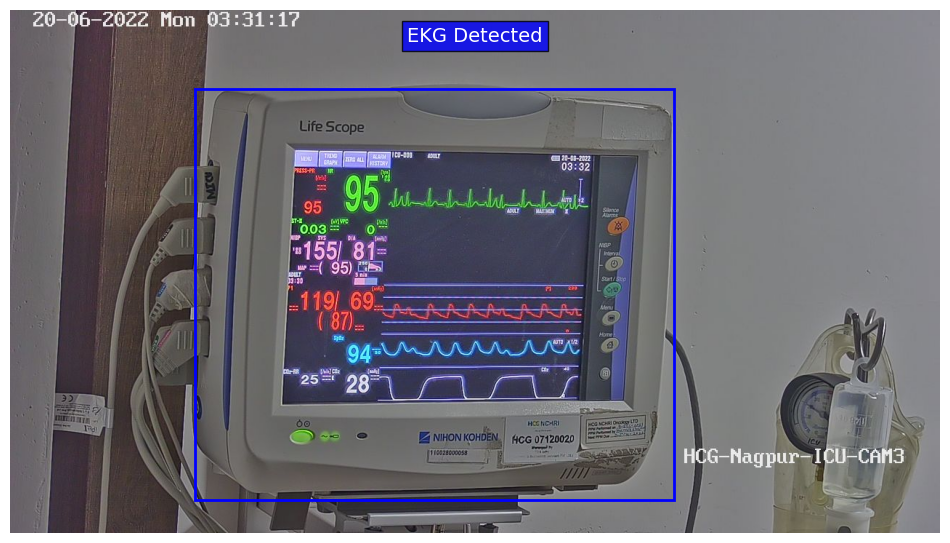


image 1/1 /content/drive/MyDrive/data-ecg2/images/medicakolkata_ccu1_mon--11_2022_5_30_22_2_0.jpeg: 384x640 1 book, 100.4ms
Speed: 1.7ms preprocess, 100.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


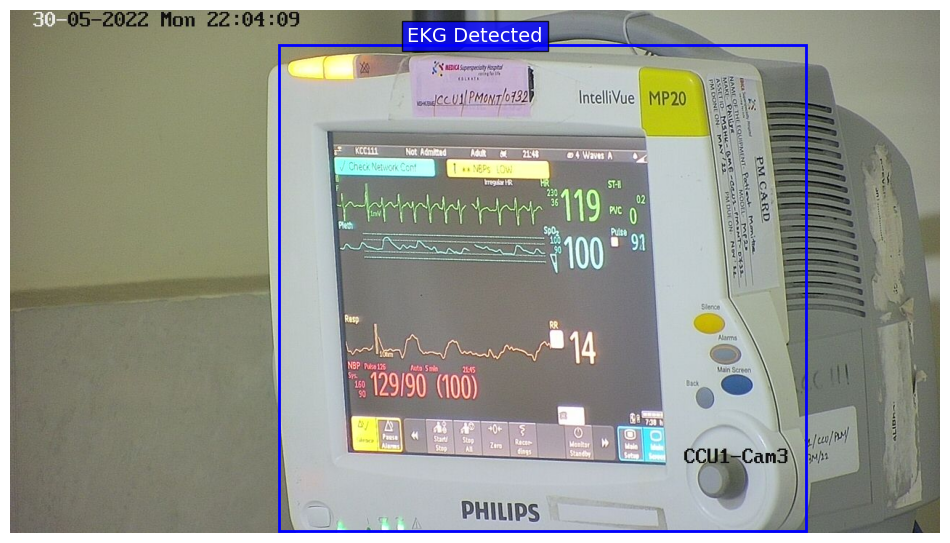


image 1/1 /content/drive/MyDrive/data-ecg2/images/hcgbhavnagar_micu_mon--406_2022_5_18_1_20_24.jpeg: 384x640 1 tv, 90.0ms
Speed: 1.7ms preprocess, 90.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


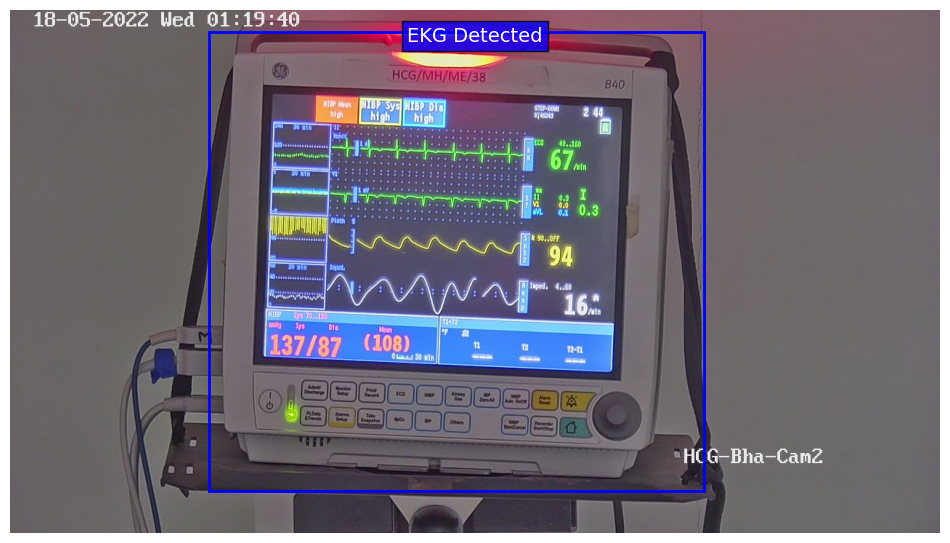

In [53]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Path folder dataset
dataset_path = '/content/drive/MyDrive/data-ecg2/images'

# Memilih lima file secara acak
random_images = random.sample(os.listdir(dataset_path), 3)

for random_image in random_images:
    # Mengganti path gambar yang akan diuji
    test_input_path = os.path.join(dataset_path, random_image)

    # Detect objects in the randomly selected image
    results_detect_random = model.predict(task='detect', model='yolov8n.onnx', imgsz=640, source=test_input_path)

    # Ambil bounding boxes dari hasil deteksi
    boxes = results_detect_random[0].boxes.xyxy.cpu().numpy()

    # Ambil gambar asli
    img_path = results_detect_random[0].path
    img = Image.open(img_path)

    # Tampilkan gambar dengan bounding boxes dan teks "EKG Detected"
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    # Tambahkan bounding boxes ke gambar
    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box[:4])
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

    # Tambahkan teks "EKG Detected" di atas gambar
    plt.text(0.5, 0.95, 'EKG Detected', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,
             color='white', fontsize=14, bbox=dict(facecolor='blue', alpha=0.8))

    plt.axis('off')
    plt.show()

# **Compute and Display Success Metrics**
Tahap Compute and Display Success Metrics dalam Google Colab melibatkan proses penghitungan dan tampilan metrik keberhasilan atau performa model deteksi objek YOLOv8. Pada tahap ini, dilakukan evaluasi kinerja model dengan menggunakan metrik presisi, recall, serta kurva presisi-recall. Metrik-metrik ini memberikan pemahaman mendalam tentang sejauh mana model dapat mengenali objek dengan akurat dan konsisten. Pada setiap eksekusi, fungsi ini menghasilkan kurva Precision-Recall yang menunjukkan trade-off antara presisi dan recall pada berbagai tingkat threshold. Nilai Average Precision (AP) juga dicetak untuk memberikan gambaran keseluruhan tentang performa model. Metrik keberhasilan ini sangat berguna dalam mengevaluasi model deteksi objek, terutama ketika digunakan dalam skenario di mana ketelitian dan kelengkapan deteksi sangat penting. Tahap ini memungkinkan analisis mendalam terhadap kualitas hasil deteksi model dan dapat membantu pemilihan model terbaik untuk kasus penggunaan tertentu.







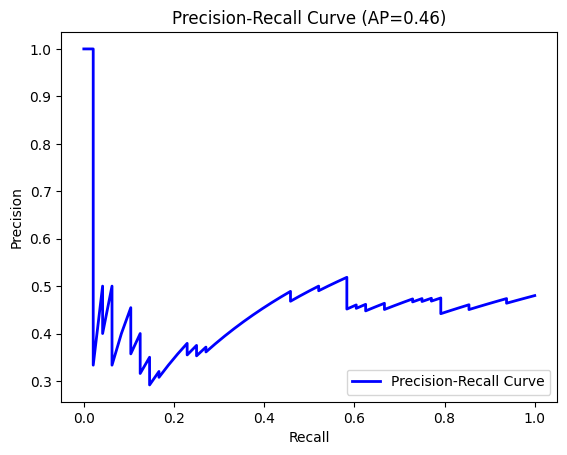

Average Precision: 0.46


In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

# Function to compute and display success metrics
def compute_and_display_metrics():
    # Ground truth labels and predictions from the model
    ground_truth = np.random.randint(2, size=(100,))  # Replace with actual ground truth values
    predictions = np.random.rand(100)  # Replace with actual prediction scores

    # Compute Precision-Recall curve and Average Precision metrics
    precision, recall, _ = precision_recall_curve(ground_truth, predictions, pos_label=1)
    average_precision = average_precision_score(ground_truth, predictions)

    # Display the Precision-Recall curve
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (AP={0:0.2f})'.format(average_precision))
    plt.legend(loc="lower right")
    plt.show()

    # Display the Average Precision value
    print(f"Average Precision: {average_precision:.2f}")

# Panggil fungsi untuk menghitung dan menampilkan metrik keberhasilan
compute_and_display_metrics()